# DAGとBackDoor基準


In [1]:
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

import matplotlib.pyplot as plt

plt.style.use(
    "ggplot"
) 

import seaborn as sns

import japanize_matplotlib
# import plotly.express as px
# import plotly.graph_objects as go
import daft

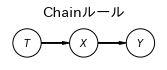

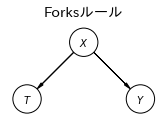

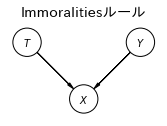

In [2]:
pgm = daft.PGM()
# Nodes
pgm.add_node(daft.Node("T", r"$T$", 0, 0))
pgm.add_node(daft.Node("X", r"$X$", 1, 0))
pgm.add_node(daft.Node("Y", r"$Y$", 2, 0))
# Edges
pgm.add_edge("T", "X")
pgm.add_edge("X", "Y")

pgm.render()
plt.title("Chainルール")
plt.show()

########
pgm = daft.PGM()
# Nodes
pgm.add_node(daft.Node("T", r"$T$", 0, 0))
pgm.add_node(daft.Node("X", r"$X$", 1, 1))
pgm.add_node(daft.Node("Y", r"$Y$", 2, 0))

# Edges
pgm.add_edge("X", "T")
pgm.add_edge("X", "Y")

pgm.render()
plt.title("Forksルール")
plt.show()
#########
pgm = daft.PGM()
# Nodes
pgm.add_node(daft.Node("T", r"$T$", 0, 1))
pgm.add_node(daft.Node("X", r"$X$", 1, 0))
pgm.add_node(daft.Node("Y", r"$Y$", 2, 1))

# Edges
pgm.add_edge("T", "X")
pgm.add_edge("Y", "X")

pgm.render()
plt.title("Immoralitiesルール")
plt.show()

#### Chain ルール
仮に真のDAGがChainルールだった場合、

In [3]:
n_points = 1000
true_t_coef = 3
true_x_coef = 2
print("真のt->yの効果は: ", true_t_coef * true_x_coef)

np.random.seed(seed=1)
t = np.random.normal(0, 50, size=n_points)

x = np.random.normal(0, 100, size=n_points) + t * true_t_coef

y = np.random.normal(0, 200, size=n_points) + x * true_x_coef

data = np.stack([t, x, y]).T
chain_df = pd.DataFrame(data, columns=["t", "x", "y"])
chain_df.head()

真のt->yの効果は:  6


,t,x,y
0,81.217268,228.328188,554.559700
1,-30.587821,-335.014313,-622.269455
2,-26.408588,-28.427329,-146.477020
3,-53.648431,-193.348526,-508.856053
4,43.270381,-21.296516,-448.582047


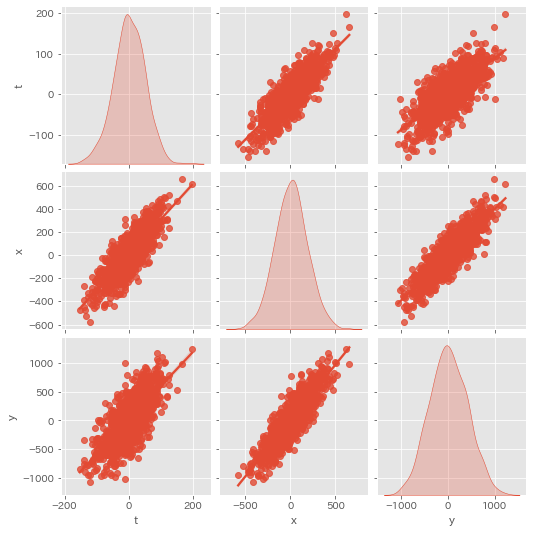

In [4]:
sns.pairplot(data=chain_df, kind="reg", diag_kind="kde")

In [5]:
# 介入変数Tのみで回帰したとき
regression = smf.ols("y ~ t", data=chain_df).fit()
regression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.2428,8.825,0.141,0.888,-16.075,18.561
t,5.8910,0.180,32.768,0.000,5.538,6.244


In [6]:
# 介入変数Tと中間変数Xで回帰したとき
regression = smf.ols("y ~ t + x", data=chain_df).fit()
regression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-3.8896,6.150,-0.632,0.527,-15.959,8.179
t,-0.0227,0.221,-0.103,0.918,-0.456,0.410
x,1.9416,0.060,32.545,0.000,1.824,2.059


 - 中間変数Xで条件つけた場合（観察した場合＝回帰係数に入れた場合）、TとYは独立になる

$$
    % align環境を使うと複数の式を&で位置合わせできる
    \begin{align*}
        P(T, X, Y) &= P(T) P(X|T) P(Y|X) \\
        P(T, Y | X) &= \frac{P(T) P(X|T) P(Y|X) }{ P(X) }  \\ 
                   &=  P(T|X) P(Y|X)
    \end{align*}
$$   

X の条件付き独立 $ T \perp\kern-5pt\perp Y \mid X$

#### Fork ルール
- 仮に真のDAGがChainルールだった場合、関心のある因果効果T->Yはどうすれば識別できるのか

In [7]:
n_points = 1000
true_xt_coef = 3
true_xy_coef = -20
true_ty_coef = 6
print("真のt->yの効果は: ", true_ty_coef)

np.random.seed(seed=1)
x = np.random.normal(0, 3, size=n_points)

t = np.random.normal(0, 2, size=n_points) + x * true_xt_coef

y = np.random.normal(0, 20, size=n_points) + x * true_xy_coef + t * true_ty_coef

data = np.stack([t, x, y]).T
fork_df = pd.DataFrame(data, columns=["t", "x", "y"])
fork_df.head()

真のt->yの効果は:  6


,t,x,y
0,14.312636,4.873036,-1.794574
1,-10.370825,-1.835269,-20.743647
2,-3.737577,-1.584515,0.302606
3,-10.304782,-3.218906,-9.666476
4,4.766515,2.596223,-63.924266


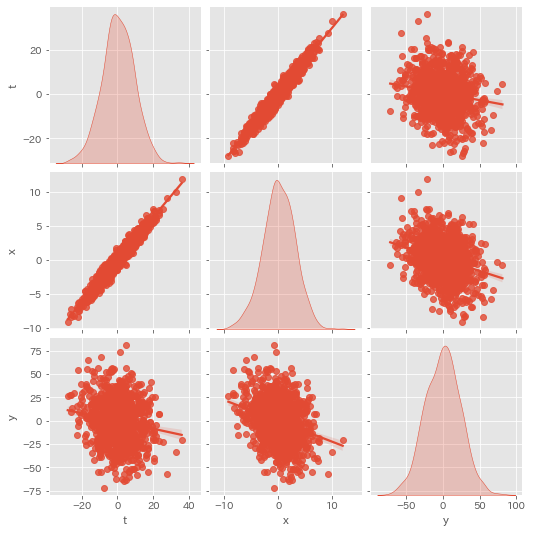

In [8]:
sns.pairplot(data=fork_df, kind="reg", diag_kind="kde")

In [9]:
# 介入変数Tのみで回帰したとき
regression = smf.ols("y ~ t", data=fork_df).fit()
regression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1811,0.739,-0.245,0.806,-1.631,1.269
t,-0.4141,0.081,-5.110,0.000,-0.573,-0.255


In [10]:
# 介入変数Tと共変量Xで回帰したとき
regression = smf.ols("y ~ t + x", data=fork_df).fit()
regression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.3890,0.615,-0.632,0.527,-1.596,0.818
t,5.7078,0.298,19.135,0.000,5.122,6.293
x,-19.4535,0.923,-21.069,0.000,-21.265,-17.642


In [11]:
# xで条件付けしてみる
def conditon_x_plot(df):
    """
    共変量Xを９分割して、各クラス内で単回帰してみる
    実質的に粗い重回帰になっている
    """
    df["class_x"] = pd.qcut(df["x"], 9).astype("str")
    cutpoint_list = sorted(df["class_x"].unique())

    list_param = []
    fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(16, 8))

    ax_list = [item for sublist in ax for item in sublist]  # axはネストしているので、解消しておく
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i, cutpoint in enumerate(cutpoint_list):
        _group = df.query("class_x == @cutpoint")
        _regression = smf.ols("y ~ t", data=_group).fit()

        sns.regplot(x="t", y="y", data=_group, ax=ax_list[i], color="b")
        ax_list[i].set_title(f"x class = {cutpoint}", fontsize=12)
        ax_list[i].text(
            0.05,
            0.95,
            f"y = {round(_regression.params[0],2)} + {round(_regression.params[1],2)}*t",
            verticalalignment="top",
            transform=ax_list[i].transAxes,
            fontsize=14,
        )

        if _regression.pvalues[1] <= 0.05:
            list_param.append(_regression.params[1])

    fig.suptitle("x1 vs. x3 | x2", fontsize=16)
    plt.show()

    return np.mean(list_param)

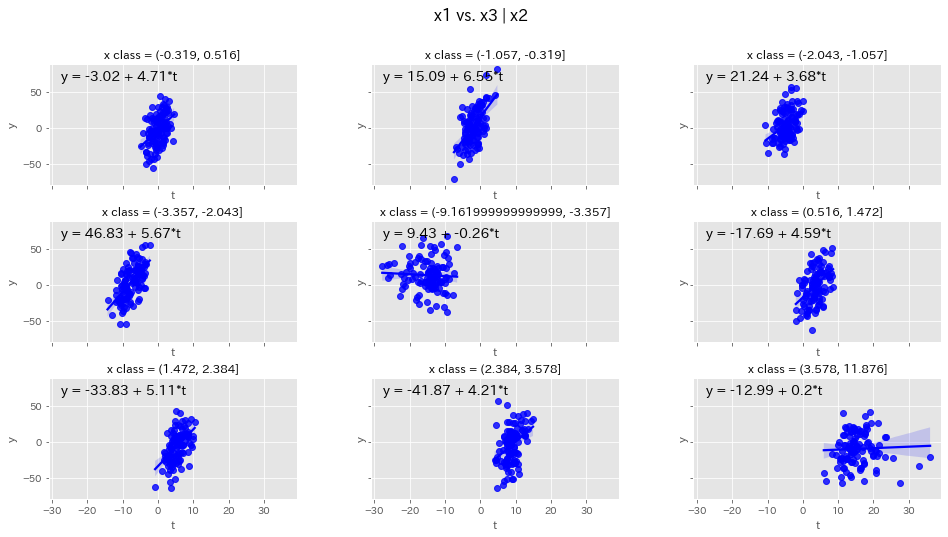

4.932336503451563

In [12]:
conditon_x_plot(fork_df)

- これも自明ではあるが、xで条件つけた場合、tとyは独立になる

$$
    \begin{align*}
        P(t, x, y) &= P(x) P(t|x) P(y|x) \\
        P(t, y | x) &=  P(t|x) P(y|x)
    \end{align*}
$$    
    
    
x の条件付き独立 $ t \perp\kern-5pt\perp y \mid x$

### Immoralitiesルール
- DAGから $ t \perp\kern-5pt\perp y$ は明らか
- $t$と$y$の同時分布　$P(t, y) = P(t) P(y)$
- ただし、共通子孫である$x$を観察した瞬間、$t \not\!\perp\!\!\!\perp y \mid x$となるので注意.
(Xの子孫を観察した場合も同じ)

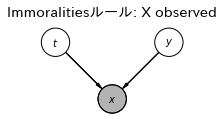

In [13]:
pgm = daft.PGM()

# Nodes
pgm.add_node(daft.Node("T", r"$t$", 0, 1))
pgm.add_node(daft.Node("X", r"$x$", 1, 0, observed=True))
pgm.add_node(daft.Node("Y", r"$y$", 2, 1))

# Edges
pgm.add_edge("T", "X")
pgm.add_edge("Y", "X")

pgm.render()
plt.title("Immoralitiesルール: X observed")
plt.show()

In [14]:
# コリンダーバイアス
# sim
n_points = 1000
true_tx_coef = 3
true_yx_coef = 2
print("真のt->yの効果は: ゼロ！")

np.random.seed(seed=1)
t = np.random.normal(0, 50, size=n_points)
y = np.random.normal(0, 30, size=n_points)
x = t * true_tx_coef + y * true_yx_coef

data = np.stack([t, x, y]).T
colliders_df = pd.DataFrame(data, columns=["t", "x", "y"])
colliders_df.head()

真のt->yの効果は: ゼロ！


,t,x,y
0,81.217268,234.457635,-4.597085
1,-30.587821,-237.713973,-72.975255
2,-26.408588,-48.746703,15.239530
3,-53.648431,-180.387233,-9.720970
4,43.270381,39.146548,-45.332298


In [15]:
# 介入変数Tのみで回帰したとき
regression = smf.ols("y ~ t", data=fork_df).fit()
regression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1811,0.739,-0.245,0.806,-1.631,1.269
t,-0.4141,0.081,-5.110,0.000,-0.573,-0.255


In [16]:
# 介入変数Tと共通子孫のみで回帰したとき
regression = smf.ols("y ~ t + x", data=fork_df).fit()
regression.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.3890,0.615,-0.632,0.527,-1.596,0.818
t,5.7078,0.298,19.135,0.000,5.122,6.293
x,-19.4535,0.923,-21.069,0.000,-21.265,-17.642


#### collidersバイアスに注意！
- 相関があるから、なんでもかんでも変数としてもってくればいいわけではない
- $t$と$y$は本来関係なかった（独立）はずなのに、その合流点$x$(もしくは、その子孫ノード)を観察（重回帰の変数として採用）してしまったばっかりに、$t$の係数は有意

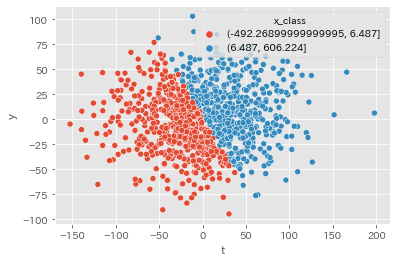

In [17]:
colliders_df["x_class"] = pd.qcut(colliders_df["x"], 2)
sns.scatterplot(x="t", y="y", data=colliders_df, hue="x_class")
plt.show()

## Definition : Backdoor Criterion
A set of variables W satisfies the backdoor criterion relative to T and Y if the following are true:
1. W blocks all backdoor paths from T to Y.
2. W does not contain any descendants of T.

(引用) : [Introduction to Causal Inference](https://www.bradyneal.com/Introduction_to_Causal_Inference-Dec17_2020-Neal.pdf)

このような変数は全て調整しよう（＝回帰式に入れよう）

## Frontdoor criterion / frontdoor adjustment


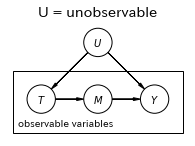

In [18]:
# frontdoor
pgm = daft.PGM(observed_style="inner")

pgm.add_node("U", r"$U$", 2, 2)

pgm.add_node("T", r"$T$", 1, 1)
pgm.add_node("M", r"$M$", 2, 1)
pgm.add_node("Y", r"$Y$", 3, 1)

pgm.add_edge("U", "T")
pgm.add_edge("U", "Y")
pgm.add_edge("T", "M")
pgm.add_edge("M", "Y")

pgm.add_plate([0.5, 0.5, 3, 1], label=r"observable variables", shift=-0.1)

pgm.render()
plt.title("U = unobservable")
plt.show()

### Frontdoor adjustment: big picture
1. Identify the causal effect of T on M
2. Identify the causal effect of M on Y
3. Combine the above steps to identify the causal effect of T on Y

(引用) : [Introduction to Causal Inference](https://www.bradyneal.com/Introduction_to_Causal_Inference-Dec17_2020-Neal.pdf)

#### 1. Identify the causal effect of T on M

- T->Mへの回帰でOK

$$
P(m | do(t)) = P(m | t)
$$

#### 2. Identify the causal effect of M on Y

- M->Yへの効果を識別する
- この場合、backdoo
r M <- T <- U -> Yが開いている状態
- 必ずTで調整する
$$
P(y | do(m)) = \sum_{t} P(y|m,t) P(t)
$$


#### 3. Combine the above steps to identify the causal effect of T on Y

- 1.と2.を掛け合わせる

$$
P(y | do(t)) = \sum_{m} P(m | do(t))P(y | do(m))
$$


真のt->yの効果は:  8


,T,U_unobsevable,M,Y
0,470.294395,162.434536,995.414652,-12270.508117
1,-453.535369,-61.175641,-880.325602,2619.745984
2,-102.065264,-52.817175,-254.319051,4375.881459
3,-357.858175,-107.296862,-784.125391,7755.086135
4,91.892785,86.540763,-43.568277,-8768.656191


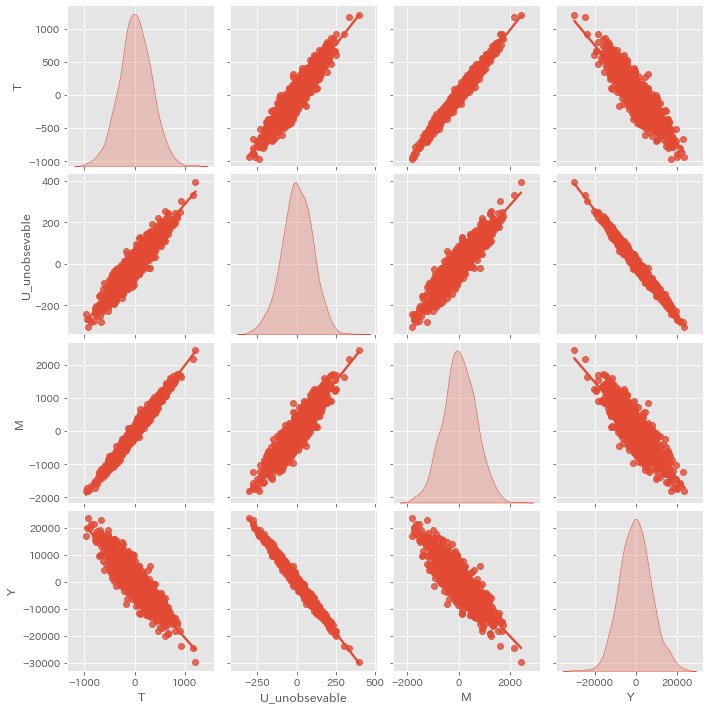

In [19]:
n_points = 1000
true_ut_coef = 3
true_uy_coef = -100
true_tm_coef = 2
true_my_coef = 4

print("真のt->yの効果は: ", true_tm_coef * true_my_coef)

np.random.seed(seed=1)
u = np.random.normal(0, 100, size=n_points)

t = np.random.normal(0, 111, size=n_points) + u * true_ut_coef

m = np.random.normal(0, 112, size=n_points) + t * true_tm_coef

y = np.random.normal(0, 113, size=n_points) + u * true_uy_coef + m * true_my_coef

data = np.stack([t, u, m, y]).T
front_df = pd.DataFrame(data, columns=["T", "U_unobsevable", "M", "Y"])

sns.pairplot(data=front_df, kind="reg", diag_kind="kde")
front_df.head()

In [20]:
true_regression = smf.ols("Y ~ T + U_unobsevable", data=front_df).fit()
print(true_regression.summary().tables[1])

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -8.6625     14.365     -0.603      0.547     -36.851      19.526
T                 7.9080      0.126     62.998      0.000       7.662       8.154
U_unobsevable   -99.8743      0.407   -245.409      0.000    -100.673     -99.076


### frontdoor調整
#### (1) t->m

In [21]:
tm_regression = smf.ols("M ~ T", data=front_df).fit()
# print(tm_regression.summary().tables[1])

tm_coef_estimated = tm_regression.params["T"]
print(f"(1) 想定 t->m: {true_tm_coef}, 推定値 t->m: {tm_coef_estimated}")

(1) 想定 t->m: 2, 推定値 t->m: 1.9800112260227365


#### (2) m->y
- Tで調整することを忘れない

In [22]:
my_regression = smf.ols("Y ~ M + T", data=front_df).fit()

my_coef_estimated = my_regression.params["M"]
print(f"(2) 想定 m->y: {true_my_coef}, 推定値 m->y: {my_coef_estimated}")

(2) 想定 m->y: 4, 推定値 m->y: 3.6897991215128583


#### (3) t->y
- あとは掛け算するだけ

In [23]:
print(
    f"(3) 想定 t->y: {true_tm_coef*true_my_coef}, 推定値 t->y: {tm_coef_estimated*my_coef_estimated}"
)

(3) 想定 t->y: 8, 推定値 t->y: 7.305843682364291


## 総合問題
### (1) これって識別可能？

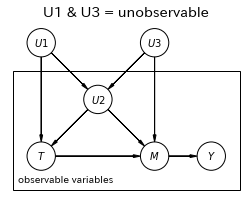

In [24]:
pgm = daft.PGM(observed_style="inner")

pgm.add_node("U1", r"$U1$", 1, 3)
pgm.add_node("U2", r"$U2$", 2, 2)
pgm.add_node("U3", r"$U3$", 3, 3)
pgm.add_node("T", r"$T$", 1, 1)
pgm.add_node("M", r"$M$", 3, 1)
pgm.add_node("Y", r"$Y$", 4, 1)

pgm.add_edge("U1", "T")
pgm.add_edge("U1", "U2")
pgm.add_edge("U2", "T")
pgm.add_edge("U2", "M")
pgm.add_edge("U3", "U2")
pgm.add_edge("U3", "M")
pgm.add_edge("T", "M")
pgm.add_edge("M", "Y")

pgm.add_plate([0.5, 0.5, 4, 2], label=r"observable variables", shift=-0.1)

pgm.render()
plt.title("U1 & U3 = unobservable")
plt.show()

### (２) これはどう？

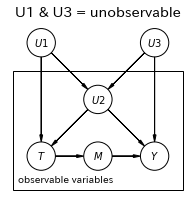

In [25]:
pgm = daft.PGM(observed_style="inner")

pgm.add_node("U1", r"$U1$", 1, 3)
pgm.add_node("U2", r"$U2$", 2, 2)
pgm.add_node("U3", r"$U3$", 3, 3)
pgm.add_node("T", r"$T$", 1, 1)
pgm.add_node("M", r"$M$", 2, 1)
pgm.add_node("Y", r"$Y$", 3, 1)

pgm.add_edge("U1", "T")
pgm.add_edge("U1", "U2")
pgm.add_edge("U2", "T")
pgm.add_edge("U2", "Y")
pgm.add_edge("U3", "U2")
pgm.add_edge("U3", "Y")
pgm.add_edge("T", "M")
pgm.add_edge("M", "Y")

pgm.add_plate([0.5, 0.5, 3, 2], label=r"observable variables", shift=-0.1)

pgm.render()
plt.title("U1 & U3 = unobservable")
plt.show()

---
## 実データで確認(BackDoor基準)
### DATA
- とても有名な職業訓練RCTデータ: [PSID and CPS Data Files](https://users.nber.org/~rdehejia/nswdata2.html)

- LaLonde(1986)[ "Evaluating the Econometric Evaluations of Training Programs with Experiment Data"](https://www.researchgate.net/publication/4900843_Evaluating_the_Econometric_Evaluations_of_Training_Programs_with_Experiment_Data)
- 条件を満たす失業者にカウンセリングと短期職業経験の実施（＝treat）するというRCT

|   name  |  意味  |
| :-------------: | :-------------: |
|  treat  |  介入|
|  age  |  年齢 |
|  education |  学歴  |
|  black  |  アフリカ系=1 or 0  |
|  hispanic  |  ヒスパニック系=1 or 0  |
| married  |  結婚有無 |
|  nodegree	  |  学位がない=1 |
| re74  |  74年の年収  |
|  re75  |  75年の年収  |
|  re78  |  78年の年収(アウトカム)  |

In [26]:
# 職業訓練のRCTデータ
# https://users.nber.org/~rdehejia/nswdata2.html
RCT_DATA = "http://www.nber.org/~rdehejia/data/nsw_dw.dta"

rct_data = pd.read_stata(RCT_DATA)


del rct_data["data_id"]  # 不要なので消す
rct_data["treat"] = rct_data["treat"].astype(int)

### (1) EDA

In [27]:
rct_data.tail(5)

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
440,0,21.0,9.0,1.0,0.0,0.0,1.0,31886.429688,12357.219727,0.000000
441,0,28.0,11.0,1.0,0.0,0.0,1.0,17491.449219,13371.250000,0.000000
442,0,29.0,9.0,0.0,1.0,0.0,1.0,9594.307617,16341.160156,16900.300781
443,0,25.0,9.0,1.0,0.0,1.0,1.0,24731.619141,16946.630859,7343.963867
444,0,22.0,10.0,0.0,0.0,1.0,1.0,25720.919922,23031.980469,5448.800781


In [28]:
# データは何行何列？
rct_data.shape

(445, 10)

In [29]:
# Nullはないかな？
rct_data.isnull().sum()

treat        0
age          0
education    0
black        0
hispanic     0
married      0
nodegree     0
re74         0
re75         0
re78         0
dtype: int64

In [30]:
rct_data.groupby("treat").mean()

,age,education,black,hispanic,married,nodegree,re74,re75,re78
treat,,,,,,,,,
0,25.053846,10.088462,0.826923,0.107692,0.153846,0.834615,2107.026611,1266.909058,4554.801270
1,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573730,1532.055298,6349.143555


<AxesSubplot:xlabel='treat', ylabel='re78'>

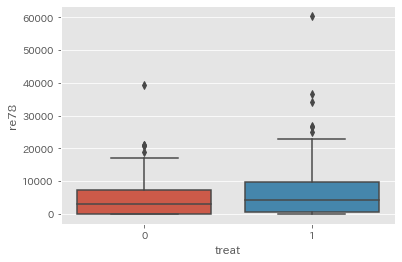

In [31]:
sns.boxplot(x="treat", y="re78", data=rct_data)

### (2) 検定

In [32]:
result_rct = rct_data.groupby("treat")["re78"].mean()
print(result_rct)
print("-"*13)
print("両群の差： ", result_rct.diff().values[1])

_, pval = stats.ttest_ind(rct_data["treat"], rct_data["re78"], equal_var=True)
if pval <= 0.05:
    print("有意に差がある p-値:", pval)

treat
0    4554.801270
1    6349.143555
Name: re78, dtype: float32
-------------
両群の差：  1794.3423
有意に差がある p-値: 1.5106742299998541e-55


### (3) 回帰バージョン

In [33]:
smf.ols("re78 ~ treat", data=rct_data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     8.039
Date:                Tue, 25 Apr 2023   Prob (F-statistic):            0.00479
Time:                        11:46:05   Log-Likelihood:                -4542.7
No. Observations:                 445   AIC:                             9089.
Df Residuals:                     443   BIC:                             9098.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4554.8011    408.046     11.162      0.000    3752.855    5356.747
treat       1794.3424    632.853      2.835      0.005     550.574    3038.110
==============================================================================
Omnibus:                      282.071   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3430.892
Skew:                           2.547   Prob(JB):                         0.00
Kurtosis:                      15.613   Cond. No.                         2.47
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

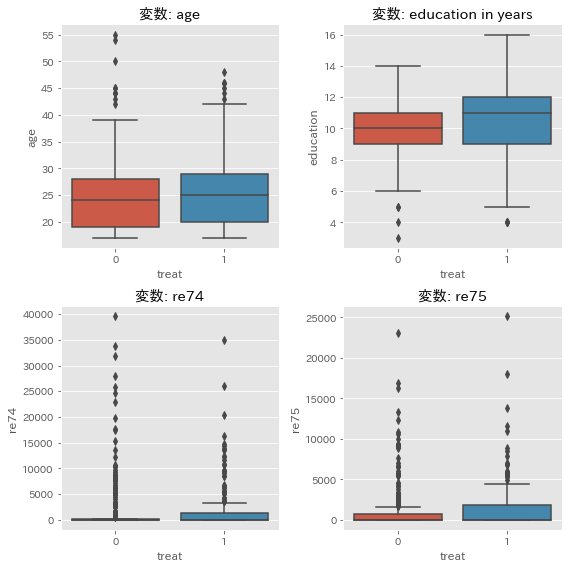

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.ravel()
sns.boxplot(x="treat", y="age", data=rct_data, ax=ax[0])
sns.boxplot(x="treat", y="education", data=rct_data, ax=ax[1])
sns.boxplot(x="treat", y="re74", data=rct_data, ax=ax[2])
sns.boxplot(x="treat", y="re75", data=rct_data, ax=ax[3])
[
    ax[i].set_title(f"変数: {_title}")
    for i, _title in enumerate(["age", "education in years", "re74", "re75"])
]
plt.tight_layout()
plt.show()

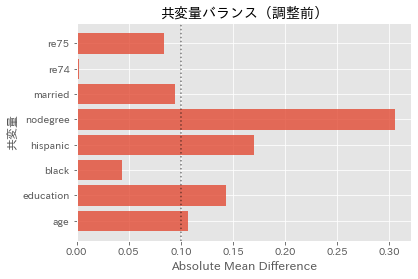

In [35]:
# 分析前の共変量バランス
def cal_abs_mean_diff(df):
    # (treatment群の平均 - control群の平均) / 全体の標準誤差
    return (
        (
            df.query("treat>0").drop("treat", axis=1).mean()
            - df.query("treat<1").drop("treat", axis=1).mean()
        )
        / df.drop("treat", axis=1).std()
    ).abs()


# 調整前のAbsolute Mean Difference
unadjusted_balance = rct_data[
    [
        "treat",
        "age",
        "education",
        "black",
        "hispanic",
        "nodegree",
        "married",
        "re74",
        "re75",
    ]
]
unadjusted_balance = cal_abs_mean_diff(unadjusted_balance)

fig, ax = plt.subplots()
ax.set_title("共変量バランス（調整前）", fontsize=14)
ax.set_xlabel("Absolute Mean Difference", fontsize=12)
ax.set_ylabel("共変量", fontsize=12)
ax.barh(unadjusted_balance.index, unadjusted_balance, alpha=0.8)
ax.axvline(x=0.1, alpha=0.5, color="black", linestyle="dotted")
plt.show()

- RCTといえど必ず共変量がコントロールできているわけではない
- 今回のデータでは少し調整した方がいいかも

In [36]:
# multi regression
all_featuers = [col for col in rct_data.columns if "re78" not in col]

multi_formula = "re78 ~ "
for i, _featuer in enumerate(all_featuers):
    if i == 0:
        multi_formula += f"{_featuer}"
    else:
        multi_formula += f" + {_featuer}"
print(multi_formula)

multi_regression = smf.ols(multi_formula, data=rct_data).fit()
multi_regression.summary()

re78 ~ treat + age + education + black + hispanic + married + nodegree + re74 + re75


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.804
Date:                Tue, 25 Apr 2023   Prob (F-statistic):            0.00329
Time:                        11:46:06   Log-Likelihood:                -4534.2
No. Observations:                 445   AIC:                             9088.
Df Residuals:                     435   BIC:                             9129.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    785.0614   3374.969      0.233      0.816   -5848.211    7418.334
treat       1676.3426    638.682      2.625      0.009     421.056    2931.629
age           55.3167     45.284      1.222      0.223     -33.686     144.319
education    395.7343    227.415      1.740      0.083     -51.234     842.703
black      -2159.5222   1169.036     -1.847      0.065   -4457.183     138.139
hispanic     164.0327   1549.457      0.106      0.916   -2881.320    3209.386
married     -138.7253    879.728     -0.158      0.875   -1867.771    1590.321
nodegree     -70.6806   1004.387     -0.070      0.944   -2044.736    1903.374
re74           0.0821      0.077      1.061      0.289      -0.070       0.234
re75           0.0528      0.135      0.389      0.697      -0.214       0.319
==============================================================================
Omnibus:                      284.809   Durbin-Watson:                   2.059
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3770.859
Skew:                           2.545   Prob(JB):                         0.00
Kurtosis:                      16.321   Cond. No.                     7.19e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### conditonal ATE
- ATEは文字通り全体平均
- 効果の異質性に関心がある場合はこれでは足りない
- 全体で効いていいても、あるセグメントでは逆効果（あるいはその逆）というケースも多々ある
- たとえば、、、

<AxesSubplot:xlabel='treat', ylabel='re78'>

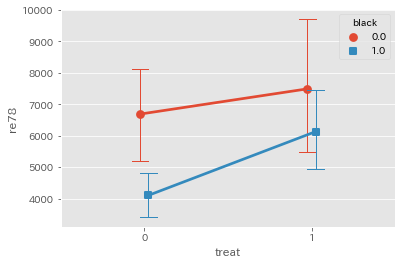

In [37]:
## bar plot
sns.pointplot(
    data=rct_data,
    x="treat",
    y="re78",
    hue="black",
    dodge=True,
    markers=["o", "s"],
    capsize=0.1,
    errwidth=1,
    #     palette="Set2",
)

- アフリカ系である場合、今回の介入はそれ以外のセグトメンに比べて大きそう？
- この効果を把握したい場合の回帰

In [38]:
multi_formula_with_interaction = multi_formula + "+ treat*black"
print(multi_formula_with_interaction)

result_with_interaction = smf.ols(multi_formula_with_interaction, data=rct_data).fit()
result_with_interaction.summary()

re78 ~ treat + age + education + black + hispanic + married + nodegree + re74 + re75+ treat*black


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   re78   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.599
Date:                Tue, 25 Apr 2023   Prob (F-statistic):            0.00452
Time:                        11:46:06   Log-Likelihood:                -4533.8
No. Observations:                 445   AIC:                             9090.
Df Residuals:                     434   BIC:                             9135.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1339.6774   3434.600      0.390      0.697   -5410.841    8090.196
treat         385.4800   1604.707      0.240      0.810   -2768.484    3539.444
age            55.7601     45.299      1.231      0.219     -33.272     144.792
education     404.0053    227.671      1.775      0.077     -43.469     851.480
black       -2926.9994   1460.602     -2.004      0.046   -5797.731     -56.267
hispanic     -133.0055   1586.453     -0.084      0.933   -3251.091    2985.080
married      -103.2785    880.890     -0.117      0.907   -1834.619    1628.062
nodegree      -50.9124   1004.907     -0.051      0.960   -2026.002    1924.177
re74            0.0814      0.077      1.051      0.294      -0.071       0.234
re75            0.0504      0.136      0.372      0.710      -0.216       0.317
treat:black  1527.9659   1742.443      0.877      0.381   -1896.710    4952.641
==============================================================================
Omnibus:                      284.263   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3746.088
Skew:                           2.540   Prob(JB):                         0.00
Kurtosis:                      16.275   Cond. No.                     7.52e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## その他のアプローチとの比較
[Comparison of Estimation Methods in Causal Inference](https://medium.com/p/16f5ac9ed122)